In [1]:
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graph_utils as gu
import networkx as nx
import json
from amg_utils import amg_impact_by_parsimony
from plotting_utils import draw_graph

In [2]:
masses = json.loads(open("model_files/masses.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amgs = json.loads(open("model_files/amg_reactions.json").read())
amg_gene_names = json.loads(open("model_files/amg_gene_map.json").read())
amg_rxn_names = {k: f"{v}: {k}" for k, v in amg_gene_names.items()}

In [3]:
model = cobra.io.read_sbml_model("./model_files/ProchlorococcusMED4+PHM2v1.xml")

In [4]:
def nearest_ind(df, v):
    return min(range(len(df.index)), key=lambda x: abs(df.index[x] - v))


def flux_at_val(df, v):
    return df.iloc[nearest_ind(df, v), 0].fluxes

In [5]:
with model as host_model:
    h_fva = cobra.flux_analysis.flux_variability_analysis(
        host_model,
        [
            host_model.reactions.AmmoniaEX,
            host_model.reactions.FAKEOrthophosphateEX,
            host_model.reactions.HCO3EXcar,
            host_model.reactions.LightEX,
        ],
    )
with model as phage_model:
    phage_model.objective = phage_model.reactions.PHM2_prodrxn_VN.flux_expression
    p_fva = cobra.flux_analysis.flux_variability_analysis(
        phage_model,
        [
            phage_model.reactions.AmmoniaEX,
            phage_model.reactions.FAKEOrthophosphateEX,
            phage_model.reactions.HCO3EXcar,
            phage_model.reactions.LightEX,
        ],
    )

print("Host-optimal")
print(h_fva)
print()
print("Phage-optimal")
print(p_fva)

Host-optimal
                          minimum    maximum
AmmoniaEX               -0.864117  -0.855149
FAKEOrthophosphateEX    -0.033099  -0.033099
HCO3EXcar            -1000.000000  -5.341752
LightEX              -1000.000000 -72.510110

Phage-optimal
                          minimum    maximum
AmmoniaEX               -1.637692  -1.637692
FAKEOrthophosphateEX    -0.187383  -0.187383
HCO3EXcar            -1000.000000  -4.917245
LightEX              -1000.000000 -56.503374


Based on the above, we will set some (highly permissive) bounds on maximum nutrient uptake

In [6]:
# (from amg_utils.py)
# BOUND_FACTOR = 5
# N_LIMIT = -0.86 * BOUND_FACTOR
# P_LIMIT = -0.18 * BOUND_FACTOR
# C_LIMIT = -5.4 * BOUND_FACTOR
# L_LIMIT = -73 * BOUND_FACTOR

In [7]:
baselines = []
infecteds = []
diffs = []
penalties = np.linspace(0, 10, 111)
baseline = amg_impact_by_parsimony(model, amgs, new_amg_penalty=0)
for amg_penalty in penalties:
    infected = amg_impact_by_parsimony(model, amgs, new_amg_penalty=-amg_penalty)
    diff = infected.fluxes - baseline.fluxes
    baselines.append(baseline)
    infecteds.append(infected)
    diffs.append(diff)

baselines = pd.DataFrame(baselines, index=penalties)
infecteds = pd.DataFrame(infecteds, index=penalties)

absdiffs = pd.DataFrame(
    [
        infected.fluxes.abs() - baseline.fluxes.abs()
        for infected, baseline in zip(
            infecteds.values.flatten(), baselines.values.flatten()
        )
    ],
    index=penalties,
)

diffs = pd.DataFrame(diffs, index=penalties)
diffs

,R01055,R00546,R05605,R00346,R00355,R00357,R00369,R00485,R00489,R00768,...,R05681,R04439,R02097,Trans_S_Malate,S_MalateEX,R01078,Trans_H2O2,H2O2EX,R02036,PHM2_prodrxn_VN
0.000000,0.0,0.0,2.442491e-14,0.0,3.136380e-15,0.0,-7.806256e-16,1.630640e-16,1.377479e-16,1.153591e-16,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.043436e-15,-1.043436e-15,2.431388e-14,0.0
0.090909,0.0,0.0,2.031708e-14,0.0,-4.596323e-14,0.0,-6.522560e-16,1.361758e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.580469e-15,-3.580469e-15,2.020606e-14,0.0
0.181818,0.0,0.0,2.031708e-14,0.0,-4.596323e-14,0.0,-6.522560e-16,1.361758e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.580469e-15,-3.580469e-15,2.020606e-14,0.0
0.272727,0.0,0.0,2.031708e-14,0.0,-4.596323e-14,0.0,-6.522560e-16,1.361758e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.580469e-15,-3.580469e-15,2.020606e-14,0.0
0.363636,0.0,0.0,2.031708e-14,0.0,-4.596323e-14,0.0,-6.522560e-16,1.361758e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,-3.580469e-15,-3.580469e-15,2.020606e-14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.636364,0.0,0.0,2.020606e-14,0.0,1.706968e-14,0.0,-6.591949e-16,1.370432e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,7.901665e-16,7.901665e-16,2.009504e-14,0.0
9.727273,0.0,0.0,2.020606e-14,0.0,1.706968e-14,0.0,-6.591949e-16,1.370432e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,7.901665e-16,7.901665e-16,2.009504e-14,0.0
9.818182,0.0,0.0,2.020606e-14,0.0,1.706968e-14,0.0,-6.591949e-16,1.370432e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,7.901665e-16,7.901665e-16,2.009504e-14,0.0
9.909091,0.0,0.0,2.020606e-14,0.0,1.706968e-14,0.0,-6.591949e-16,1.370432e-16,6.884684e-17,9.714451e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,7.901665e-16,7.901665e-16,2.009504e-14,0.0


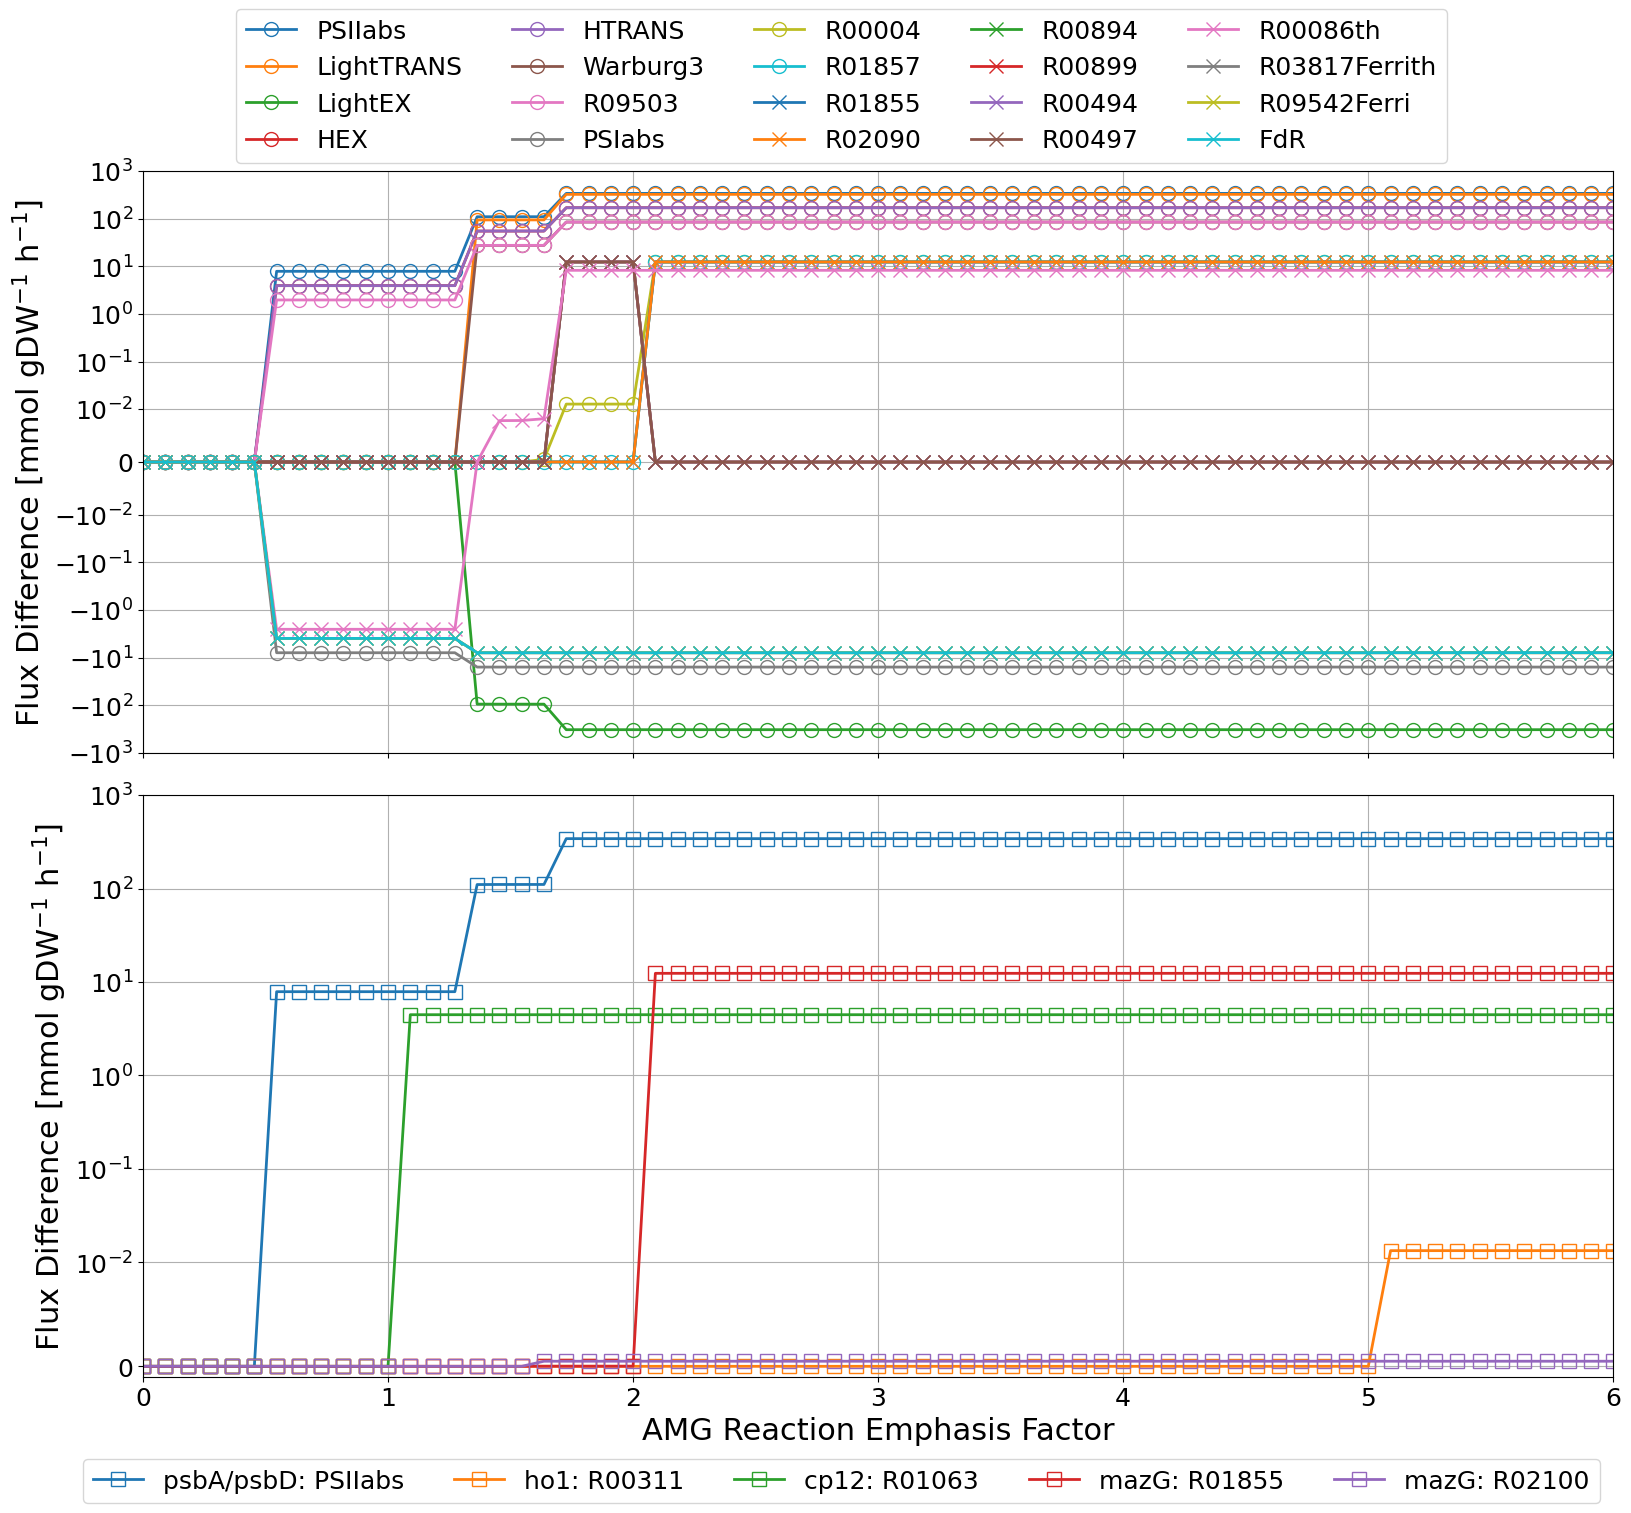

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)
top10 = diffs.abs().max(axis=0).sort_values(ascending=False)[0:10].index
next10 = diffs.abs().max(axis=0).sort_values(ascending=False)[10:20].index
diffs[top10].plot(
    ax=axs[0],
    marker="o",
    fillstyle="none",
    linewidth=2,
    markersize=10,
)
diffs[next10].plot(
    ax=axs[0],
    marker="x",
    fillstyle="none",
    linewidth=2,
    markersize=10,
)

axs[0].set_yscale("symlog", linthresh=1e-2)
axs[0].tick_params(labelsize=18)
axs[0].legend(ncols=5, loc="upper center", bbox_to_anchor=(0.475, 1.3), fontsize=18)
axs[0].set_xlim(0, 6)
axs[0].set_ylim(-1e3, 1e3)
axs[0].set_xlabel("AMG Reaction Emphasis Factor", fontsize=22)
axs[0].set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=22)
axs[0].grid(True, which="both")
# plt.show()
(
    diffs[[col for col in amgs if diffs[col].abs().max() > 1e-7]]
    # * np.random.uniform(0.9, 1.1, (len(diffs), 10)) # uncomment to add noise to check for overlap
).plot(
    ax=axs[1],
    marker="s",
    fillstyle="none",
    linewidth=2,
    markersize=10,
)
axs[1].set_yscale("symlog", linthresh=1e-2)
axs[1].tick_params(labelsize=18)

_, lab = axs[1].get_legend_handles_labels()
axs[1].legend(
    [amg_rxn_names[g] for g in lab],
    ncols=5,
    loc="upper center",
    bbox_to_anchor=(0.475, -0.12),
    fontsize=18,
)
axs[1].set_xlim(0, 6)
axs[1].set_ylim(-1e-3, 1e3)
axs[1].set_xlabel("AMG Reaction Emphasis Factor", fontsize=22)
axs[1].set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=22)
axs[1].grid(True, which="both")
fig.tight_layout()
plt.show()

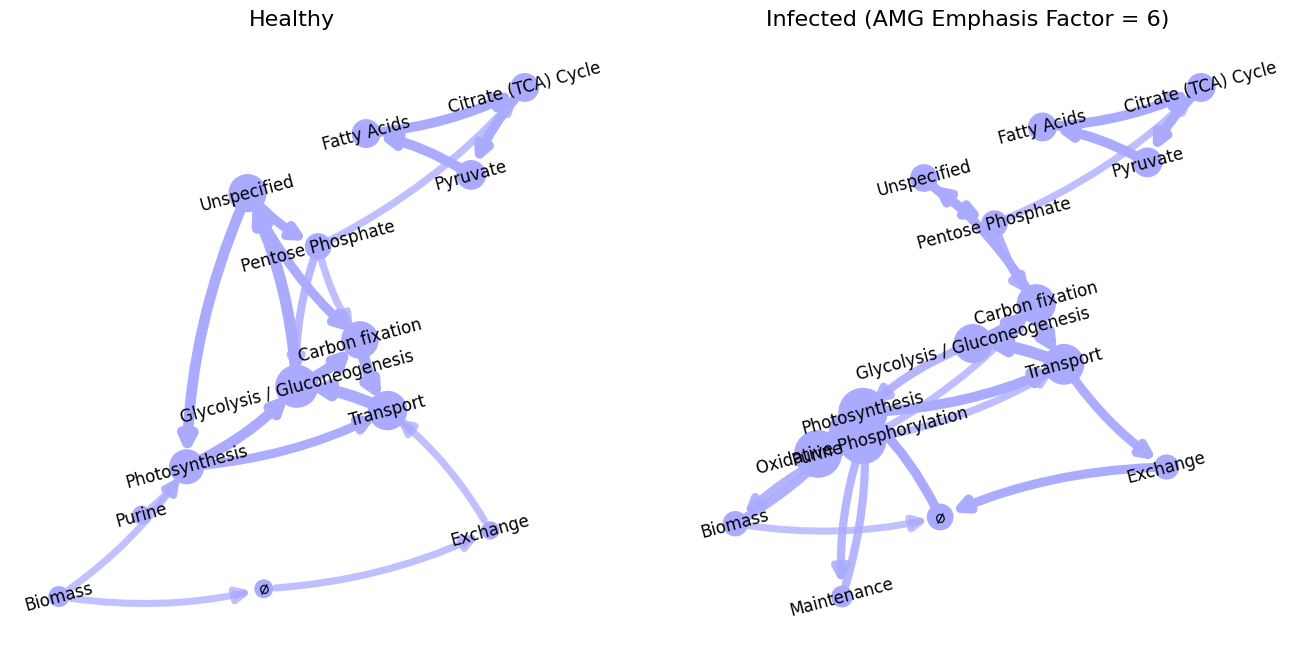

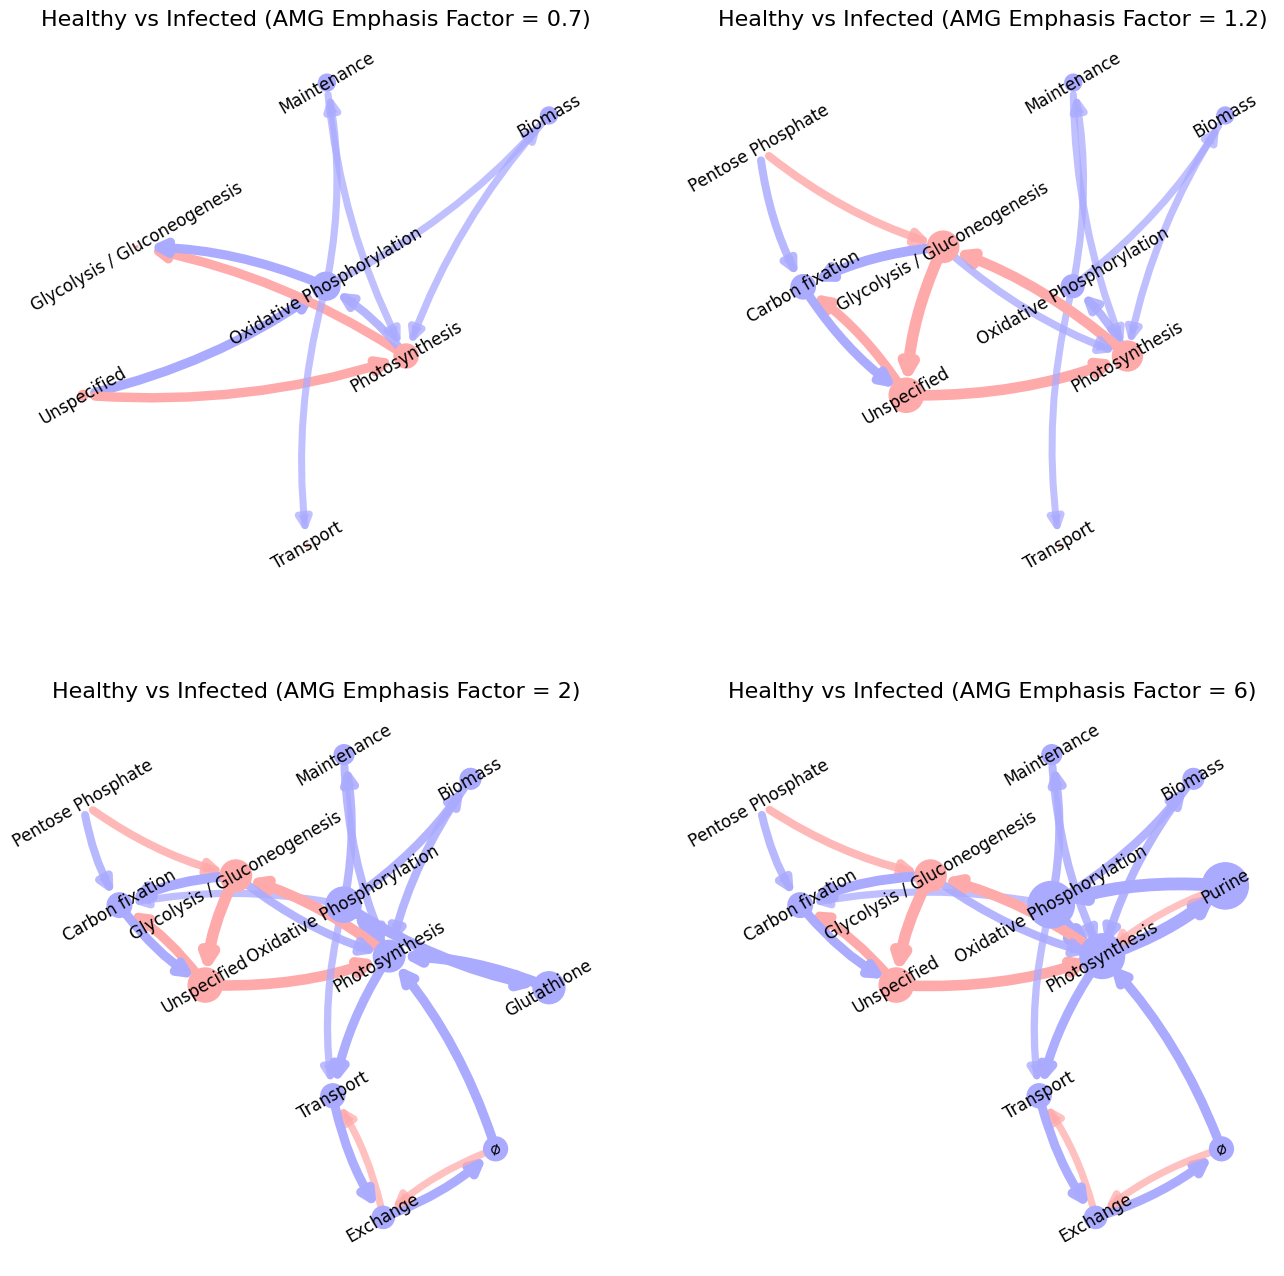

In [9]:
factor = 6
scale = 4
cut = 30 / scale
g_healthy = gu.subsystem_flux_graph(
    model,
    flux_at_val(baselines, factor),
    masses=masses,
)
g_infected = gu.subsystem_flux_graph(
    model,
    flux_at_val(infecteds, factor),
    masses=masses,
)
pos = nx.layout.fruchterman_reingold_layout(g_infected, seed=0, k=3, iterations=150)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
draw_graph(
    g_healthy, axs[0], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
draw_graph(
    g_infected, axs[1], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
axs[0].set_title("Healthy", fontsize=16)
axs[1].set_title(f"Infected (AMG Emphasis Factor = {factor})", fontsize=16)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
flist = [0.7, 1.2, 2, 6]

# pos = None
pg = nx.DiGraph()
for r in range(2):
    for ax, factor in zip(axs.flatten(), flist):
        g_healthy = gu.subsystem_flux_graph(
            model,
            flux_at_val(baselines, factor),
            masses=masses,
        )
        g_infected = gu.subsystem_flux_graph(
            model,
            flux_at_val(infecteds, factor),
            masses=masses,
        )

        g_diff = gu.diff_graph(g_infected, g_healthy)

        gs_red = g_diff.edge_subgraph(
            [
                (u, v)
                for u, v, d in g_diff.edges(data=True)
                if np.abs(d["weight"] / scale) > cut
            ]
        )
        if r:
            # if pos is None:
            #     pos = nx.shell_layout(pg)
            pos = nx.layout.kamada_kawai_layout(pg, weight=None)
            draw_graph(
                g_diff,
                ax,
                cut=cut,
                manual_relabels=manual_relabels,
                pos=pos,
                scale=scale,
                label_rotation=30,
            )
            ax.set_title(
                f"Healthy vs Infected (AMG Emphasis Factor = {factor})", fontsize=16
            )
        else:
            pg.add_edges_from(gs_red.edges())
plt.show()

In [10]:
sys_diffs_in = {}
for factor in penalties:
    g_infected = gu.subsystem_flux_graph(
        model,
        flux_at_val(infecteds, factor),
        masses=masses,
    )
    g_healthy = gu.subsystem_flux_graph(
        model,
        flux_at_val(baselines, factor),
        masses=masses,
    )

    g_diff = gu.diff_graph(g_infected, g_healthy)
    # g_diff = g_healthy
    # g_diff = g_infected
    if "AMG Emphasis Factor" in sys_diffs_in:
        sys_diffs_in["AMG Emphasis Factor"].append(factor)
    else:
        sys_diffs_in["AMG Emphasis Factor"] = [factor]
    for u in g_diff.nodes():
        deg = g_diff.in_degree(u, weight="weight")
        if u in sys_diffs_in:
            sys_diffs_in[u].append(deg / 1000)
        else:
            sys_diffs_in[u] = [deg / 1000]

sys_diffs_in = pd.DataFrame(sys_diffs_in)
sys_diffs_in.columns = [manual_relabels.get(u, u) for u in sys_diffs_in.columns]


In [11]:
sys_diffs_in.index = sys_diffs_in["AMG Emphasis Factor"]
sys_diffs_in = sys_diffs_in.drop("AMG Emphasis Factor", axis=1)
sys_diffs_in

,Pyrimidine,Alanine / Aspartate / Glutamate,Pentose Phosphate,Pyruvate,Amino sugar and nucleotide sugar metabolism,Aminoacyl-tRNA biosynthesis,Arginine / Proline,Biomass,Biotin metabolism,Butanoate metabolism,...,Sulfur metabolism,Terpenoid Backbone,Thiamine,tRNA Formation,Ubiquinone and other terpenoid-quinone biosynthesis,Valine / Leucine / Isoleucine,"Valine, leucine and isoleucine degradation",Exchange,Unspecified,⌀
AMG Emphasis Factor,,,,,,,,,,,,,,,,,,,,,
0.000000,6.385358e-16,-1.841270e-16,5.673247e-15,9.791919e-15,9.684919e-17,0.0,6.803423e-16,2.423122e-15,6.747207e-18,0.0,...,4.329870e-17,4.011420e-16,2.207286e-18,0.0,0.0,2.103662e-16,2.221556e-16,-2.920775e-15,2.694355e-14,1.110478e-14
0.090909,5.061937e-16,-6.582277e-15,-8.809811e-15,1.885707e-15,8.123607e-17,0.0,1.171126e-15,2.261264e-15,5.682954e-18,0.0,...,3.619327e-17,3.371867e-16,1.811329e-18,0.0,0.0,1.715050e-16,1.851297e-16,-1.422085e-14,-6.473669e-14,1.635192e-15
0.181818,5.132991e-16,-6.582277e-15,-8.809811e-15,1.885707e-15,8.123390e-17,0.0,1.175595e-15,2.261264e-15,5.681219e-18,0.0,...,3.619327e-17,3.441811e-16,1.811329e-18,0.0,0.0,1.696974e-16,1.851297e-16,-1.422085e-14,-6.511906e-14,1.700806e-15
0.272727,5.061937e-16,-6.582277e-15,-8.809811e-15,1.885707e-15,8.123607e-17,0.0,1.171126e-15,2.261264e-15,5.682954e-18,0.0,...,3.619327e-17,3.371867e-16,1.811329e-18,0.0,0.0,1.715050e-16,1.851297e-16,-1.422085e-14,-6.473669e-14,1.635192e-15
0.363636,5.132991e-16,-6.582277e-15,-8.809811e-15,1.885707e-15,8.123390e-17,0.0,1.175595e-15,2.261264e-15,5.681219e-18,0.0,...,3.619327e-17,3.441811e-16,1.811329e-18,0.0,0.0,1.696974e-16,1.851297e-16,-1.422085e-14,-6.511906e-14,1.700806e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.636364,2.054772e-05,1.458369e-15,8.516906e-15,2.664503e-03,-6.707195e-09,0.0,-3.691749e-04,7.981527e-02,6.334416e-07,0.0,...,5.690778e-07,1.196092e-03,-1.523347e-06,0.0,0.0,1.170071e-05,1.874056e-16,1.041091e-01,-5.866239e-01,1.384257e-01
9.727273,2.054772e-05,1.458369e-15,8.516906e-15,2.664503e-03,-6.707195e-09,0.0,-3.691749e-04,7.981527e-02,6.334416e-07,0.0,...,5.690778e-07,1.196092e-03,-1.523347e-06,0.0,0.0,1.170071e-05,1.874056e-16,1.041091e-01,-5.866239e-01,1.384257e-01
9.818182,2.054772e-05,1.458369e-15,8.516906e-15,2.664503e-03,-6.707195e-09,0.0,-3.691749e-04,7.981527e-02,6.334416e-07,0.0,...,5.690778e-07,1.196092e-03,-1.523347e-06,0.0,0.0,1.170071e-05,1.874056e-16,1.041091e-01,-5.866239e-01,1.384257e-01


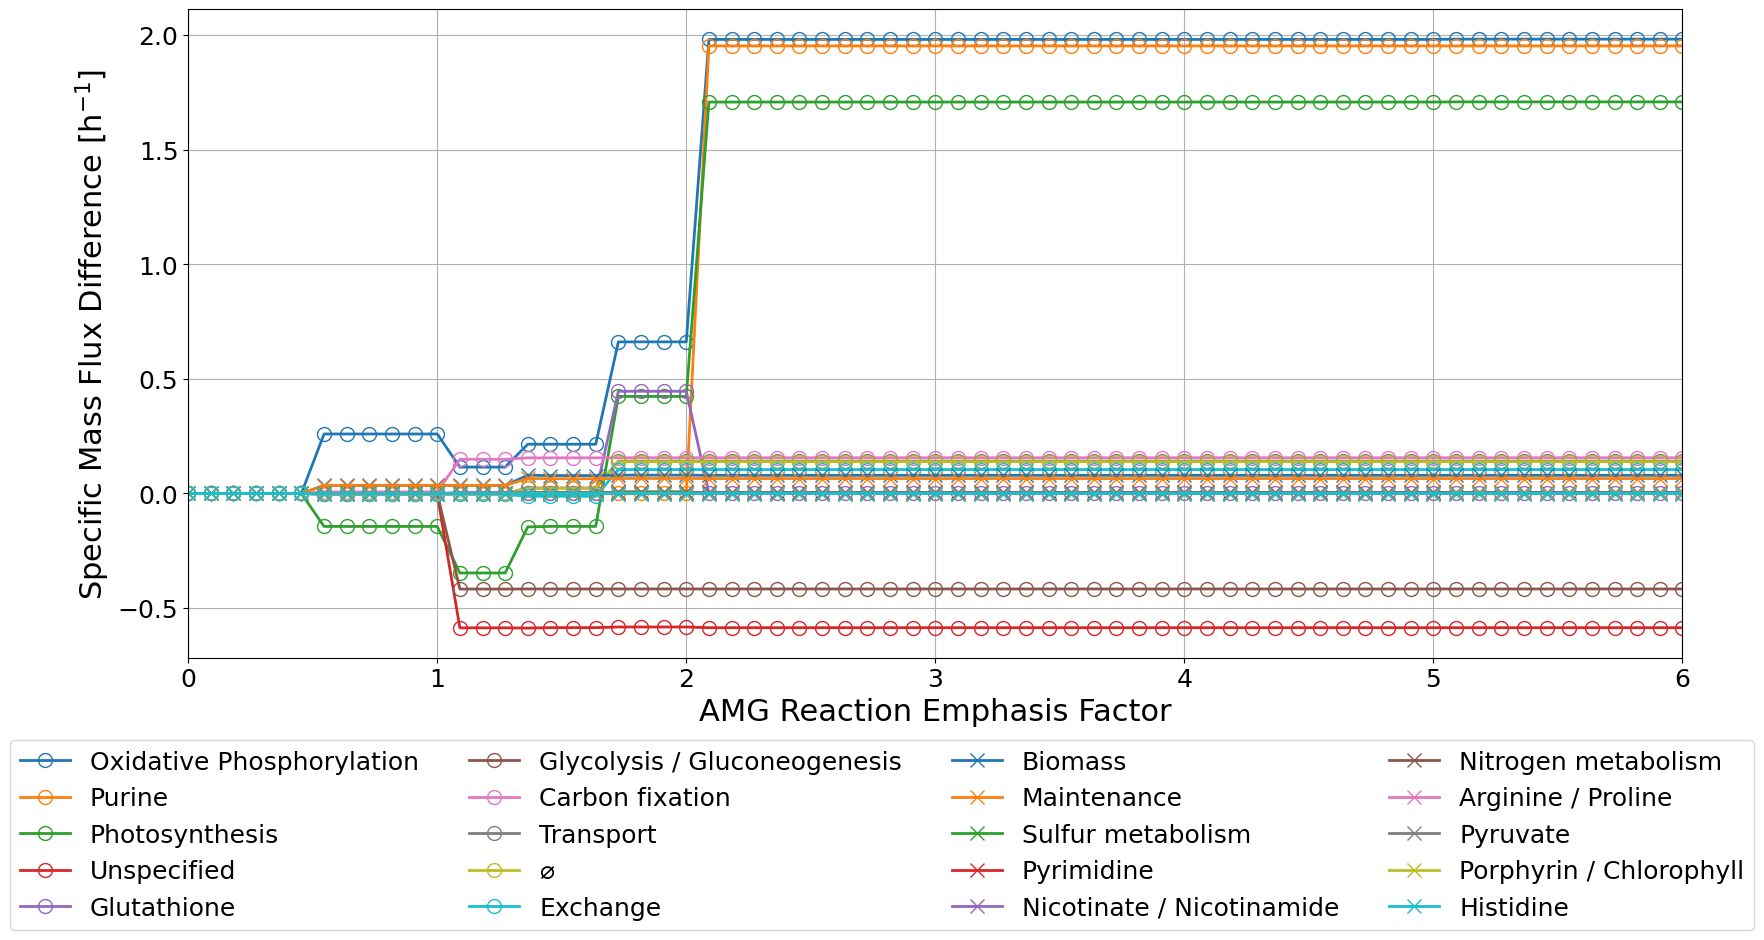

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8), sharex=True)
top10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[0:10].index
next10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[10:20].index
sys_diffs_in[top10sys].plot(
    ax=ax,
    marker="o",
    fillstyle="none",
    linewidth=2,
    markersize=10,
    legend=False,
)
sys_diffs_in[next10sys].plot(
    ax=ax,
    marker="x",
    fillstyle="none",
    linewidth=2,
    markersize=10,
    legend=False,
)
# ax = sys_diffs_in[
#     [
#         col
#         for col in sys_diffs_in.columns
#         if (0.100 >= sys_diffs_in[col].abs().max() > 0.001) or "AMG" in col
#     ]
# ].plot(
#     x="AMG Emphasis Factor",
#     marker="x",
#     fillstyle="none",
#     ax=ax,
#     legend=False,
#     linewidth=2,
#     markersize=10,
# )
# ax.set_yscale("symlog", linthresh=0.01)
ax.tick_params(labelsize=18)
fig.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 0.05), fontsize=18)
ax.set_xlim(0, 6)
ax.set_xlabel("AMG Reaction Emphasis Factor", fontsize=22)
ax.set_ylabel(
    r"Specific Mass Flux Difference [h$^{-1}$]",
    fontsize=22,
)
ax.grid(True, which="both")

fig.tight_layout(pad=3.0)
plt.show()